# 신발 추천 서비스 : JordanRecommend

In [1]:
import pandas as pd
# import pickle

# 피클에서 df 불러오기
with open("jordan_embedding_dict_df.pkl","rb") as f:
    df = pd.read_pickle(f)
df

,model_no,file_path,model_code,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,553558-053,./image_224/553558-053.png,553558-053,0.026309,0.446112,0.022441,1.665069,0.355164,0.144774,1.407430,...,0.030451,0.417743,0.194275,0.258652,1.559767,0.127391,0.000000,0.008930,0.165795,0.014965
1,DM7866-140,./image_224/DM7866-140.png,DM7866-140,0.023389,0.002546,0.070857,1.287806,0.055228,0.225909,0.670382,...,0.738315,1.002537,0.152530,0.066414,2.004650,1.125030,0.000000,0.080334,0.151629,0.101394
2,555088-105,./image_224/555088-105.png,555088-105,0.004161,0.074477,0.544856,1.673943,0.251016,0.020887,1.004260,...,0.358522,0.425758,0.008596,0.454090,0.769909,0.546023,0.000000,0.032915,0.107209,1.022224
3,DH6927-111,./image_224/DH6927-111.png,DH6927-111,0.692499,1.410187,0.445121,2.663520,0.498345,0.282219,1.345795,...,0.592597,0.301277,0.816238,0.165051,0.383379,0.784562,0.121596,0.000000,0.276481,1.744524
4,555088-108,./image_224/555088-108.png,555088-108,0.393879,0.517403,0.992474,3.637862,0.340433,0.027730,1.791372,...,0.037359,0.098551,0.091971,0.516889,0.133902,1.154353,0.004665,0.000000,0.044736,0.797515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,CD7071-001,./image_224/CD7071-001.png,CD7071-001,0.293715,1.417441,0.174254,0.029442,0.079922,0.200246,0.003974,...,0.724916,0.383581,0.021155,0.082321,1.888880,0.509080,0.007205,0.014406,0.000178,0.000000
2989,810551-050,./image_224/810551-050.png,810551-050,1.487948,0.992507,0.144529,0.004882,0.317066,0.414079,0.020820,...,1.399022,0.047412,0.099896,0.080328,0.858762,1.160617,0.010359,0.003236,0.093413,0.007161
2990,852625-650,./image_224/852625-650.png,852625-650,0.664668,0.681816,0.093948,2.271096,0.343624,0.213577,0.000000,...,0.703582,0.165587,0.052237,1.422426,2.205470,1.258458,0.003407,0.065258,0.153471,1.007956
2991,AH7233-105,./image_224/AH7233-105.png,AH7233-105,0.576534,0.610457,0.747367,1.387222,1.859859,0.066439,0.723445,...,0.034282,1.423089,0.108783,0.190838,0.727266,0.028120,0.000418,0.085302,0.221600,0.003892


In [2]:
class JordanRecommend:
    
    import os

    # OMP_NUM_THREADS 환경변수를 1로 지정: prevent memory from leaking
    os.environ['OMP_NUM_THREADS'] = "1"
    
    def __init__(self,k_num=8,opt=False, random_state=42):
        
#         print('__init__ 실행')

        import pandas as pd
        # import pickle
        from sklearn.cluster import KMeans


        # 피클에서 df 불러오기
        with open("jordan_embedding_dict_df.pkl","rb") as f:
            self.__df = pd.read_pickle(f)
            
        # 변하지 않는 멤버 변수 초기화 
        self.df = self.__df.loc[:,0:511] # 임베딩 벡터 
        self.df_ = self.__df.loc[:,['model_code','file_path']] # 모델 이름, 이미지파일 위치
        
        # 변하는 멤버변수 초기화
        self.dfm = self.df.copy()
        self.df_m = self.df_.copy()
        
        # k_num, opt, random_state 초기화
        self.opt = opt
        self.random_state = random_state

#         if self.opt == True:
#             self.silhouette()
#         else:
#             self.k_num = k_num
        self.k_num = k_num
    
    
        
        # kmean 초기화
        self.kmeans = KMeans(n_clusters=self.k_num, random_state=self.random_state,verbose=0,init="k-means++",n_init=10)
        self.labels = self.kmeans.fit_predict(self.dfm)
        self.df_m['cluster'] = self.labels # df_m 의 컬럼 ['index', 'model_code','file_path', 'cluster']
        
        
        self.show_samples(self.dfm, self.df_m)
        
        
        
    def show_samples(self,dfm,df_m):
#         print('show_samples 실행')
        import matplotlib.pyplot as plt
        from PIL import Image
        import random
        
        print('현재 k_num : '+str(self.k_num))
        print('현재 df_m 개수 : '+str(len(self.df_m)))
        
        self.dfm = dfm
        self.df_m = df_m
        
        # 현재 k_num 을 바탕으로 현재 df_m 에 존재하는 클러스터 별 샘플 그리기
        
        if self.k_num < len(self.df_m):

            fig, ax = plt.subplots(1,self.k_num)
            fig.set_size_inches(20,2)
            
            for i in range(self.k_num): # 여기 위치에서는 k_num 과 cluster 수가 같아야한다.

                df = self.return_cluster_num_df(i+1) # for 문 i 에 따라 df가 변경

                img_loc = df.file_path.tolist()
                random.shuffle(img_loc)
                ax[i].axis('off')
                ax[i].set_title(f'{i+1}')
                img = Image.open(img_loc[0])
                ax[i].imshow(img)

            plt.show()
            
            self.recommend()
        
        
        
        else: # self.k_num >= len(self.df_m) 일 때
            print('************************here is my recommend************************')

            fig, ax = plt.subplots(1,len(self.df_m))
            fig.set_size_inches(20,2)
            
            if len(self.df_m) ==1: # ax가 1개 이므로 ax[1] 라 표현하면 not subscriptable error 발생
                for j,k in zip(self.df_m['file_path'], self.df_m['model_code']):

                    ax.axis('off')
                    ax.set_title(k)
                    img = Image.open(j)
                    ax.imshow(img)

                plt.show()

            else:
                
                for i,j,k in zip(range(len(self.df_m)), self.df_m['file_path'], self.df_m['model_code']):

                    ax[i].axis('off')
                    ax[i].set_title(k)
                    img = Image.open(j)
                    ax[i].imshow(img)

                plt.show()
                
            print('\n********************************************************************\n')

            return 0


            
            
            
    def recommend(self):
#         print('recommend 실행')
        self.input1 = input('Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : ')
        print('현재 k_num : '+str(self.k_num))
        try:

            if int(self.input1) <= self.k_num:
                self.select(int(self.input1))

            else:
                print("\n\n*****************************************************************************")
                print("************************Please enter a number under "+str(self.k_num)+"************************")
                print("*****************************************************************************\n\n")

                self.recommend()


        except:
            
            if self.input1 == 're':
                print('\n\n***********************************************************')
                print('************************reshuffling************************')
                print('***********************************************************\n\n')
                self.show_samples(self.dfm,self.df_m)
                self.recommend()

            else:
                print('\n\n************************************************************************')
                print('************************Please enter it correctly************************')
                print('************************************************************************\n\n')
                self.recommend()



    def select(self,num):
        
#         print('select 실행')
        import matplotlib.pyplot as plt
        from PIL import Image
        import random
        from sklearn.cluster import KMeans



        self.silhouette() # opt = True일 때 self.k_num 을 최적으로 결정

        if self.k_num > len(self.df_m):
            self.show_samples(self.dfm, self.df_m)
        else:
            
            self.df_m = self.return_cluster_num_df(num)
            self.dfm = self.df.loc[self.df_m.index]
            
            
            if self.k_num > len(self.df_m):
                self.show_samples(self.dfm, self.df_m)

            else:
                self.kmeans = KMeans(n_clusters=self.k_num, random_state=self.random_state,verbose=0,init="k-means++",n_init=10)
                self.labels = self.kmeans.fit_predict(self.dfm)
                self.df_m = self.df_m.drop(columns=['cluster'])
                self.df_m['cluster'] = self.labels
                self.dfm = self.df.loc[self.df_m.index]

                self.show_samples(self.dfm, self.df_m)


        
        
    def return_cluster_num_df(self,num): # num에 해당하는 클러스터 df를 반환하는 함수 
        
        return self.df_m[self.df_m['cluster']==num-1] # -1 의미 : 클러스터가 0부터 표현되기 때문
        

        
    def silhouette(self):

        import copy
        import numpy as np
        
        
        if self.opt==True:
        
            from sklearn.cluster import KMeans
            from sklearn.metrics import silhouette_samples, silhouette_score
            import pandas as pd
            import copy
            average_score_dict = dict()

            try:
                print('최적의 분류를 위해 silhouette 계수를 계산중입니다. 잠시만 기다려주세요')
                for i in range(4,10):

                    df0 = copy.deepcopy(self.dfm)
                    kmeans = KMeans(n_clusters= i,random_state=self.random_state,verbose=0,init="k-means++",n_init=10)
                    labels = kmeans.fit_predict(df0.loc[:,0:511])
                    df0['cluster'] = labels

                    # 모든 데이터의 평균 실루엣 계수값을 구함. 
                    average_score = silhouette_score(df0.loc[:,0:511], labels)
                    average_score_dict[f'{i}'] = average_score

                self.k_num = np.array(list(average_score_dict.values())).argmax()+4
                print('실루엣 후 k_num = ' +str(self.k_num))
            except:
                pass

        else:
            pass
        

In [3]:
# 서비스 시작을 위해 아래의 코드를 실행해주세요

현재 k_num : 6
현재 df_m 개수 : 2993


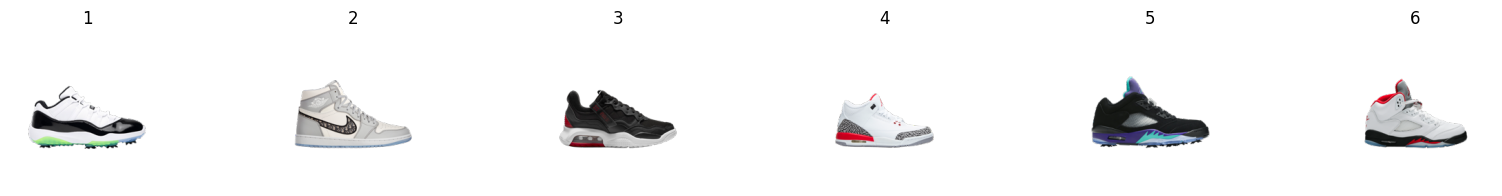

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input :  1


현재 k_num : 6
최적의 분류를 위해 silhouette 계수를 계산중입니다. 잠시만 기다려주세요
실루엣 후 k_num = 5
현재 k_num : 5
현재 df_m 개수 : 499


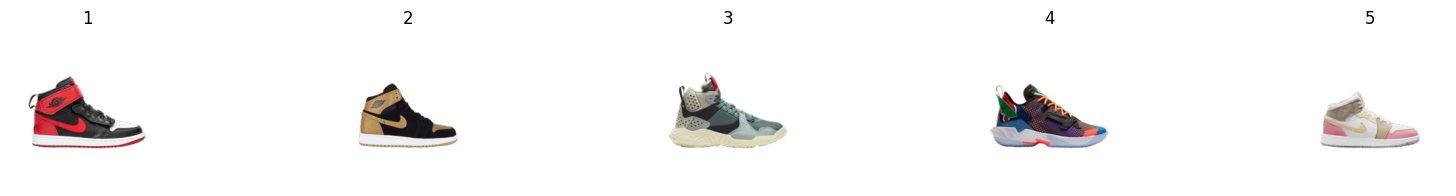

In [ ]:
JordanRecommend(k_num=6,opt=True,random_state=50) # opt=True 일 때 k_num 은 무시됨, k_num=8 random_state=42 opt =False 이 default